<a href="https://colab.research.google.com/github/BarGinger/DIS-Assignment/blob/main/Src/dis_notebook_09_11_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1st cell - Install requirements
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
!pip install graphframes
!pip install sparkmeasure==0.24
!pip install matplotlib seaborn
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 39.6 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package libxtst6:amd64.
(Reading database ... 123623 files and directories currently installed.)
Preparing to unpack .../libxtst6_2%3a1.2.3-1build4_amd64.deb ...
Unpacking libxtst6:amd64 (2:1.2.3-1build4) ...
Selecting previously unselected package openjdk-8-jre-headless:amd64.
Preparing to unpack .../openjdk-8-jre-headless_8u422-b05-1~22.04_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u422-b05-1~22.04) ...
Sel

In [2]:
# 2nd cell - Import libraries
import pyspark
from pyspark.sql import SparkSession, Row, DataFrame
from pyspark.sql.functions import (
    col,
    udf,
    row_number,
    countDistinct,
    collect_list,
    struct,
    count,
    sum,
    avg,
    expr,
    percentile_approx,
    max as spark_max,
    explode,
    round,
    rand,
    monotonically_increasing_id,
    array,
    lit,
    broadcast,
    lag,
    pandas_udf,
    PandasUDFType,
    least,
    greatest
)
import pyspark.sql.functions as F
from sparkmeasure import StageMetrics
from pyspark.sql.types import (
    StringType, IntegerType, BinaryType, DoubleType,
    ArrayType, StructType, StructField, LongType, TimestampType
)
from pyspark.sql import Window
from datetime import datetime, timedelta
from graphframes import GraphFrame
from scipy.sparse import csr_matrix, vstack, hstack
import numpy as np
import pandas as pd
import pickle
import gc
import base64
from sparkmeasure import StageMetrics # for resources monitoring
from functools import wraps
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
from operator import truediv
from google.colab import files
from itertools import combinations
from scipy.sparse.linalg import inv
from scipy.sparse import identity
from sklearn.metrics.pairwise import cosine_similarity
import shutil
import zipfile

In [3]:
# 3rd cell - Initialize Spark session
spark, stagemetrics = None, None

def create_spark():
 # Initialize Spark session with optimized memory configurations
  spark = SparkSession.builder \
        .appName("PhoneCallsCommunityDetection") \
        .master("local[*]") \
        .config("spark.jars.packages", "ch.cern.sparkmeasure:spark-measure_2.12:0.24,graphframes:graphframes:0.8.2-spark3.1-s_2.12") \
        .config("spark.executor.memory", "50G") \
        .config("spark.driver.memory", "100G") \
        .config("spark.executor.memoryOverhead", "2G") \
        .getOrCreate()

  # Initialize StageMetrics
  stagemetrics = StageMetrics(spark)

  # Optional: Set logging level to reduce verbosity
  # spark.sparkContext.setLogLevel("WARN")

  # Set a checkpoint directory for Spark
  spark.sparkContext.setCheckpointDir("/tmp/spark-checkpoints")
  return spark, stagemetrics

def kill_spark(spark):
  spark.stop()

spark, stagemetrics = create_spark()

In [ ]:
# 4th cell - Generate datasets - PLEASE only run this if datasets folder is empty / does not exists
def generate_communities(spark, num_communities, community_size_range, density=0.3, extra_factor=1.5):
    """
    Generate isolated communities with controlled sizes and connections.
    Ensures enough connections for the sample count by using an extra factor.
    """
    communities = []
    for community_id in range(num_communities):
        size = random.randint(community_size_range[0], community_size_range[1])
        base_id = community_id * 1000
        community_clients = [(community_id, base_id + i, base_id + j)
                             for i in range(size) for j in range(i + 1, size) if random.random() < density * extra_factor]
        communities.extend(community_clients)

    return spark.createDataFrame(communities, ["community_id", "client1", "client2"])

def generate_call_times(communities_df, calls_per_connection_range, duration_range, base_time, num_samples):
    """
    Generate call start and end times for each client connection, ensuring total number of samples matches `num_samples`.
    """
    calls_df = communities_df.withColumn(
        "num_calls",
        F.expr(f"floor(rand() * ({calls_per_connection_range[1]} - {calls_per_connection_range[0]} + 1)) + {calls_per_connection_range[0]}")
    ).withColumn(
        "call_id", F.monotonically_increasing_id()
    ).withColumn(
        "calls", F.expr("sequence(1, num_calls)")
    ).select("client1", "client2", "call_id", F.explode("calls").alias("call_num"))

    def generate_times():
        start_time = base_time + timedelta(minutes=random.randint(0, 1440))
        duration = random.randint(duration_range[0], duration_range[1])
        end_time = start_time + timedelta(minutes=duration)
        return start_time.strftime('%y%m%d%H%M'), end_time.strftime('%y%m%d%H%M')

    time_udf = F.udf(lambda: generate_times(), "struct<Start_Time:string, End_Time:string>")
    calls_df = calls_df.withColumn("call_times", time_udf())

    # Ensure consistent schema for the final DataFrame
    calls_df = calls_df.select(
        "client1", "client2", calls_df["call_times.Start_Time"].alias("Start_Time"), calls_df["call_times.End_Time"].alias("End_Time")
    )

    # Limit to the specified number of samples
    final_calls_df = calls_df.limit(num_samples)

    # Retry generation if the sample count isn't met
    while final_calls_df.count() < num_samples:
        additional_df = calls_df.limit(num_samples - final_calls_df.count()).select("client1", "client2", "Start_Time", "End_Time")
        final_calls_df = final_calls_df.union(additional_df).limit(num_samples)

    return final_calls_df

# Function to delete all generated datasets
def delete_generated_datasets():
    folder_path = "/content/datasets/"
    deleted_files = []

    if os.path.exists(folder_path):
        # Loop through each item in the folder
        for item in os.listdir(folder_path):
            item_path = os.path.join(folder_path, item)
            # Check if it's a directory and remove it with shutil.rmtree
            if os.path.isdir(item_path):
                shutil.rmtree(item_path)
            else:
                os.remove(item_path)
            deleted_files.append(item)

        # Print the results
        if deleted_files:
            print("Deleted the following items:")
            for item in deleted_files:
                print(item)
        else:
            print("No files found in the folder to delete.")
    else:
        print("The folder does not exist.")

def save_dataset(dataset, filename):
    """
    Save the generated dataset to a temporary directory and then move to the final directory.

    Parameters:
        dataset (DataFrame): The DataFrame to save, containing generated call data.
        filename (str): Base name for the dataset file.
    """
    # Define the directories
    final_dir = "/content/datasets"
    temp_dir = f"{final_dir}/{filename}_temp"
    final_path = os.path.join(final_dir, filename)

    # Create directories if they don't exist
    os.makedirs(final_dir, exist_ok=True)

    # Write to the temporary directory
    dataset.write.mode("overwrite").option("header", "true").csv(temp_dir)

    # Move the content to the final directory
    if os.path.exists(final_path):
        shutil.rmtree(final_path)
    shutil.move(temp_dir, final_path)

    # Clean up by removing the temporary directory
    if os.path.exists(temp_dir):
        shutil.rmtree(temp_dir)

    print(f"Dataset saved as {final_path}")
    # files.download(final_path)
    return final_path


def export_datasets_to_computer(folder_path="/content/datasets"):
    """
    Compresses and exports each dataset in the specified folder to download to the local computer.

    Parameters:
        folder_path (str): The path to the folder containing datasets.
    """
    # Check if the folder exists
    if not os.path.exists(folder_path):
        print(f"The folder '{folder_path}' does not exist.")
        return

    # Iterate over each file/directory in the folder
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)

        # If it's a directory (dataset in CSV format is usually saved as a directory)
        if os.path.isdir(item_path):
            # Create a zip file of the dataset directory
            zip_filename = f"{item}.zip"
            shutil.make_archive(item_path, 'zip', item_path)
            print(f"Compressed '{item}' as '{zip_filename}'.")

            # Download the zip file
            files.download(f"{item_path}.zip")
        else:
            # Download individual files if they are directly in the folder
            files.download(item_path)

    print("All datasets have been exported to your computer.")

In [4]:
# 5th cell - Uplode datasets into collab

def import_datasets_from_computer(folder_path="/content/datasets"):
    """
    Uploads zip files from the local computer and unzips each into the specified folder on Colab.

    Parameters:
        folder_path (str): The path to the folder where datasets will be saved after unzipping.
    """
    # Ensure the target folder exists
    os.makedirs(folder_path, exist_ok=True)

    # Upload zip files from the local computer
    uploaded_files = files.upload()

    # Process each uploaded zip file
    for filename in uploaded_files.keys():
        if filename.endswith(".zip"):
            zip_path = os.path.join(folder_path, filename)

            # Move uploaded zip file to the target folder
            os.rename(filename, zip_path)

            # Unzip the file into a subdirectory named after the zip file (without .zip extension)
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                extract_dir = os.path.join(folder_path, filename.replace(".zip", ""))
                os.makedirs(extract_dir, exist_ok=True)
                zip_ref.extractall(extract_dir)

            print(f"Imported and unzipped '{filename}' into '{extract_dir}'.")
        else:
            print(f"Skipped non-zip file '{filename}'.")

    print("All datasets have been imported and unzipped.")

import_datasets_from_computer()

In [ ]:
# 6th cell - Initialize resource monitoring

# Monitor CPU, Memory and running time
def track_stage(stage_name):
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            print(f"Starting {stage_name}")
            stagemetrics.begin()  # Begin collecting metrics for this stage

            result = func(*args, **kwargs)  # Run the actual function

            stagemetrics.end()  # Stop collecting metrics for this stage

            time.sleep(15)

            # Generate metrics DataFrame
            print(f"Completed {stage_name}\n")
            df_metrics_all = stagemetrics.create_stagemetrics_DF()
            df_metrics_agg = stagemetrics.aggregate_stagemetrics_DF()
            # Add stage_name column and join metrics and memory DataFrames
            df_metrics_agg = df_metrics_agg.withColumn("stage_name", pyspark.sql.functions.lit(stage_name))
            df_metrics_agg = df_metrics_agg.withColumn("dataset", pyspark.sql.functions.lit(dataset_file_path))
            df_metrics_agg.show(truncate=False)

            # Set write mode based on the stage
            if "Stage 1" in stage_name and clear_csv:
                write_mode = "overwrite"
                header = "true"
            else:
                write_mode = "append"
                header = "true"

            # Write metrics to CSV with appropriate mode and header settings
            df_metrics_agg.coalesce(1).write \
                .mode(write_mode) \
                .option("header", header) \
                .csv(f"{dataset_name}_stage_metrics")

            return result
        return wrapper
    return decorator

In [ ]:
# 7th cell - All the utilities functions for the project

# Convert YYMMDDHHMM to a proper datetime object
def calculate_duration_minutes(start_time, end_time):
  """
  Calculate the duration between two times in minutes.

  Parameters:
  -----------
  start_time : str
      The start time in HH:MM:SS format.
  end_time : str
      The end time in HH:MM:SS format.

  Returns:
  --------
  duration_minutes : float
      The duration between start_time and end_time in minutes.
  """
  start_datetime = convert_to_datetime(start_time)
  end_datetime = convert_to_datetime(end_time)
  duration = end_datetime - start_datetime
  duration_minutes = duration.total_seconds() / 60
  return duration_minutes

def convert_to_datetime(time_str):
  """
  Convert a time string in '%y%m%d%H%M' format to a datetime object.

  Parameters:
  -----------
  time_str : str
      The time string in '%y%m%d%H%M' format.

  Returns:
  --------
  datetime_obj : datetime.datetime
      The datetime object representing the given time string.
  """
  # Use datetime.datetime.strptime to parse the time string
  # This is the correct way to use strptime, avoiding the AttributeError
  return datetime.strptime(str(time_str), '%y%m%d%H%M')

# Define UDF for calculating duration in DDHHMM format
def calculate_duration_string(start_time, end_time):
    start_dt = convert_to_datetime(start_time)
    end_dt = convert_to_datetime(end_time)
    duration = end_dt - start_dt

    days = duration.days
    hours, remainder = divmod(duration.seconds, 3600)
    minutes = remainder // 60
    return f'{days:02d}{hours:02d}{minutes:02d}'


'''Decorator and Function Definition:
The @pandas_udf decorator marks this function as a Pandas UDF (User Defined Function) that will be applied on grouped data.
GROUPED_MAP tells Spark that the function will receive a DataFrame for each group (grouped by community_id).
The schema defines the expected output structure of the function, which is a DataFrame with community_id
and a binary field containing the serialized matrix.
The function converts the connections (edges) between clients into a CSR matrix and serializes it for storage.'''


# Define the schema for the Pandas UDF output
schema = StructType([
    StructField("community_id", IntegerType(), True),
    StructField("csr_matrix", BinaryType(), True)
])

@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def create_csr_matrix_from_edges(members_df):
    """
    Creates a serialized CSR matrix from a Spark DataFrame for each community.

    Args:
        members_df (DataFrame): Spark DataFrame with 'community_id' and 'members' columns.

    Returns:
        DataFrame: A DataFrame with 'community_id' and a serialized CSR matrix as binary data.
    """
    # try:
    # Extract the community ID (assuming it's consistent within the group)
    # members_df.show(truncate=False)
    community_id = members_df['community_id'].iloc[0]

    '''Since each members_df contains data for a single community (due to groupBy operation),
    the function retrieves the community_id from the first row.
    This ID will be included in the output so that each serialized CSR matrix can be linked back
    to its respective community.'''
    # Explode the members array to get each connection in separate rows
    exploded_df = members_df.explode("members").dropna().reset_index(drop=True)
    exploded_df = pd.DataFrame({
        'Client1': exploded_df['members'].apply(lambda x: x['Client1']),
        'Client2': exploded_df['members'].apply(lambda x: x['Client2']),
        'total_duration_minutes': exploded_df['members'].apply(lambda x: x['total_duration_minutes'])
    })
    '''Flattening and Extracting Connection Data:
    The members_df contains a column with a list of connections (pairs of clients and call durations).
    The function uses explode to convert this list into individual rows, making it easier to work with each connection.
    It then creates a new DataFrame, exploded_df, with separate columns for Client1, Client2, and duration_minutes
    extracted from the connection data.
    This simplifies further processing by ensuring each row represents a single call between two clients.'''
    # Get unique clients and create a mapping to indices
    unique_clients = sorted(pd.concat([exploded_df['Client1'], exploded_df['Client2']]).unique())
    client_to_index = {client: i for i, client in enumerate(unique_clients)}
    num_clients = len(unique_clients)

    # Extract data for CSR matrix
    rows = exploded_df['Client1'].map(client_to_index).values
    cols = exploded_df['Client2'].map(client_to_index).values
    print(f"use_weights = {use_weights}")
    if use_weights:
      print("we are inside use_weights true")
      data = exploded_df['total_duration_minutes'].values #if weight else [1] * len(rows)
    else:
      print("we are inside use_weights false")
      data = [1] * len(rows)

    # Create CSR matrix
    csr = csr_matrix((data, (rows, cols)), shape=(num_clients, num_clients))

    '''Serializing the CSR Matrix: The function uses Python’s pickle module to serialize the CSR matrix.
    This converts the matrix into a binary format, allowing it to be stored or transferred efficiently.
    Serialization is necessary because Spark DataFrames cannot directly store complex Python objects like CSR matrices.'''
    # Serialize CSR matrix to binary format
    serialized_csr = pickle.dumps(csr)

    # Return as DataFrame
    return pd.DataFrame({"community_id": [community_id], "csr_matrix": [serialized_csr]})


# prompt: print csr_matrix_result pretty
def pretty_print_csr_matrix(csr_matrix_result):
    """Prints a CSR matrix in a readable format."""

    # Extract the serialized CSR matrix from the DataFrame
    serialized_csr = csr_matrix_result.select("csr_matrix").first()[0]

    # Deserialize the CSR matrix
    csr = pickle.loads(serialized_csr)

    # Check if the result is indeed a CSR matrix
    if isinstance(csr, csr_matrix):
        # Get non-zero entries for pretty printing
        rows, cols = csr.nonzero()
        data = csr.data

        for row, col, value in zip(rows, cols, data):
            print(f"({row}, {col}): {value}")
    else:
        print("The provided data is not a CSR matrix.")

# Padding and calculating DeltaCon similarity
def pad_csr_matrix(csr, max_shape):
    current_rows, current_cols = csr.shape
    max_rows, max_cols = max_shape
    if current_rows < max_rows:
        additional_rows = csr_matrix((max_rows - current_rows, current_cols))
        csr = vstack([csr, additional_rows])
    if current_cols < max_cols:
        additional_cols = csr_matrix((csr.shape[0], max_cols - current_cols))
        csr = hstack([csr, additional_cols])
    return csr

# Pad CSR matrices and calculate DeltaCon similarity using Spark DataFrame operations
def process_csr_matrices(df, max_size, attribtue='true_csr_matrix'):
    def pad_and_calculate(row):
        csr_matrix_padded = pad_csr_matrix(pickle.loads(row[attribtue]), max_size)
        serialized_csr = pickle.dumps(csr_matrix_padded)
        return (row['community_id'], serialized_csr)

    return df.rdd.map(pad_and_calculate).toDF(["community_id", "csr_matrix"])

def frobenius_norm(csr_1, csr_2):
    """
    Compute Frobenius norm between two sparse matrices.

    Parameters:
    csr_1, csr_2 : csr_matrix
        Sparse adjacency matrices of the graphs.

    Returns:
    float
        Frobenius norm distance between the graphs.
    """
    assert csr_1.shape == csr_2.shape, "Adjacency matrices must have the same dimensions."
    diff = csr_1 - csr_2
    frobenius_norm_value = np.sqrt((diff.power(2)).sum())

    # Find the maximum value within both matrices
    max_value = max(csr_1.max(), csr_2.max())

    # Normalize the Frobenius norm by the maximum value
    normalized_frobenius = frobenius_norm_value / max_value if max_value != 0 else frobenius_norm_value

    return normalized_frobenius

def frobenius_sim(csr_1, csr_2):
    """
    Adds a similarity column to the DataFrame based on Frobenius distance.

    Parameters:
    df (DataFrame): Input DataFrame containing 'frobenius_distance' column.

    Returns:
    DataFrame: A DataFrame with an additional 'similarity' column.
    """
    dist=frobenius_norm(csr_1, csr_2)
    return 1 / (1 + dist)


def deltacon_similarity(csr_1, csr_2, epsilon=0.5):
    # Ensure both matrices are of the same size
    assert csr_1.shape == csr_2.shape, "Adjacency matrices must be of the same size for comparison."
    I = identity(csr_1.shape[0])
    D1 = csr_1.sum(axis=1).A.flatten()
    D1 = csr_matrix((D1, (range(csr_1.shape[0]), range(csr_1.shape[0]))))
    D2 = csr_2.sum(axis=1).A.flatten()
    D2 = csr_matrix((D2, (range(csr_2.shape[0]), range(csr_2.shape[0]))))

    S1 = inv(I + epsilon**2 * D1 - epsilon * csr_1)
    S2 = inv(I + epsilon**2 * D2 - epsilon * csr_2)
    frobenius_norm = np.sqrt(((S1 - S2).power(2)).sum())
    return 1 / (1 + frobenius_norm)

# Define function to calculate Frobenius similarity
def calculate_frobenius_similarity(grouped_df):
    community_id_1 = grouped_df.iloc[0]['community_id']
    community_id_2 = grouped_df.iloc[0]['community_id_2']
    csr_1 = pickle.loads(grouped_df.iloc[0]['csr_matrix'])
    csr_2 = pickle.loads(grouped_df.iloc[0]['csr_matrix_2'])
    similarity_score_f = frobenius_sim(csr_1, csr_2)
    return pd.DataFrame([{
        "community_id_1": community_id_1,
        "community_id_2": community_id_2,
        "frobenius_similarity": similarity_score_f
    }])

# Define function to calculate DeltaCon similarity
def calculate_deltacon_similarity(grouped_df):
    community_id_1 = grouped_df.iloc[0]['community_id']
    community_id_2 = grouped_df.iloc[0]['community_id_2']
    csr_1 = pickle.loads(grouped_df.iloc[0]['csr_matrix'])
    csr_2 = pickle.loads(grouped_df.iloc[0]['csr_matrix_2'])
    similarity_score_d = deltacon_similarity(csr_1, csr_2)
    return pd.DataFrame([{
        "community_id_1": community_id_1,
        "community_id_2": community_id_2,
        "deltacon": similarity_score_d
    }])

# Comparison function for structural and weight-based similarities
def cosine_sim(csr_1, csr_2):
    # Compute cosine similarity
    cosine_sim = cosine_similarity(csr_1, csr_2)
    return cosine_sim


def calculate_similarities(subgroup_community_members):
  """
  Comparing CSR matrices to detect similarity
  """

  max_size = subgroup_community_members.rdd.map(lambda row: pickle.loads(row['true_csr_matrix']).shape).reduce(lambda x, y: (max(x[0], y[0]), max(x[1], y[1])))
  padded_result_true = process_csr_matrices(subgroup_community_members, max_size, "true_csr_matrix")
  padded_result_false = process_csr_matrices(subgroup_community_members, max_size, "false_csr_matrix")

  # Step 1: Compute Frobenius Similarity (using padded_result_true)
  # Rename columns from df2 to remove ambiguity for Frobenius similarity calculation
  padded_result_true_renamed = padded_result_true.select(
      col("community_id").alias("community_id_2"),
      col("csr_matrix").alias("csr_matrix_2")
  )

  # Cross join to compare every community for Frobenius similarity
  cross_joined_df_frobenius = padded_result_true.alias("df1").crossJoin(padded_result_true_renamed.alias("df2")) \
      .filter(col("df1.community_id") < col("df2.community_id_2"))

  # Define schema for Frobenius similarity output
  frobenius_similarity_schema = StructType([
      StructField("community_id_1", IntegerType(), True),
      StructField("community_id_2", IntegerType(), True),
      StructField("frobenius_similarity", DoubleType(), True)
  ])

  # Apply Frobenius similarity calculation
  frobenius_similarity_df = cross_joined_df_frobenius.select(
      "df1.community_id", "df2.community_id_2", "df1.csr_matrix", "df2.csr_matrix_2"
  ).groupBy("community_id", "community_id_2") \
      .applyInPandas(calculate_frobenius_similarity, schema=frobenius_similarity_schema)

  #Step 2: Compute DeltaCon Similarity (using padded_result_false)

  # Rename columns from df2 to remove ambiguity for DeltaCon similarity calculation
  padded_result_false_renamed = padded_result_false.select(
      col("community_id").alias("community_id_2"),
      col("csr_matrix").alias("csr_matrix_2")
  )

  # Cross join to compare every community for DeltaCon similarity
  cross_joined_df_deltacon = padded_result_false.alias("df1").crossJoin(padded_result_false_renamed.alias("df2")) \
      .filter(col("df1.community_id") < col("df2.community_id_2"))

  # Define schema for DeltaCon similarity output
  deltacon_similarity_schema = StructType([
      StructField("community_id_1", IntegerType(), True),
      StructField("community_id_2", IntegerType(), True),
      StructField("deltacon", DoubleType(), True)
  ])

  # Apply DeltaCon similarity calculation
  deltacon_similarity_df = cross_joined_df_deltacon.select(
      "df1.community_id", "df2.community_id_2", "df1.csr_matrix", "df2.csr_matrix_2"
  ).groupBy("community_id", "community_id_2") \
      .applyInPandas(calculate_deltacon_similarity, schema=deltacon_similarity_schema)

  # Step 3: Join Results and Calculate Final Similarity Score
  # Join the Frobenius and DeltaCon similarity DataFrames
  combined_similarity_df = frobenius_similarity_df.join(
      deltacon_similarity_df,
      on=["community_id_1", "community_id_2"],
      how="inner"
  )

  # Calculate the final similarity score as an average of Frobenius and DeltaCon similarities
  final_similarity_df = combined_similarity_df.withColumn(
      "final_similarity",
      expr("0.5 * frobenius_similarity + 0.5 * deltacon")
  )

  # Show the final results
  final_similarity_df.show(truncate=False)
  return final_similarity_df

  @pandas_udf(schema_similarity, PandasUDFType.GROUPED_MAP)
  def calculate_similarity(df):
      csr_1 = pickle.loads(df['csr_matrix_1'].iloc[0])
      csr_2 = pickle.loads(df['csr_matrix_2'].iloc[0])
      similarity = deltacon_similarity(csr_1, csr_2)
      return pd.DataFrame({"community_id_1": [df['community_id_1'].iloc[0]], "community_id_2": [df['community_id_2'].iloc[0]], "similarity": [similarity]})

  cross_joined = cross_joined.select(
      col("df1.community_id").alias("community_id_1"),
      col("df2.community_id").alias("community_id_2"),
      col("df1.csr_matrix").alias("csr_matrix_1"),
      col("df2.csr_matrix").alias("csr_matrix_2")
  )

  similarities = cross_joined.groupBy("community_id_1", "community_id_2").apply(calculate_similarity)

  similarities.show(truncate=False)

@track_stage("Stage 3: Calculate similarities between communities")
def create_adaptive_buckets(df, columns, min_size=2):
    """
    Create adaptive buckets for specified columns based on natural grouping of close values.

    Parameters:
        df (DataFrame): The input DataFrame with community statistics.
        columns (list): List of column names to bucketize.
        min_size (int): Minimum number of communities required in each bucket.

    Returns:
        DataFrame: The DataFrame with additional columns for each adaptive bucket.
    """
    for column in columns:
        bucket_col = f"{column}_bucket"

        # Calculate approximate quantiles for balanced bucketing
        quantiles = [i / min_size for i in range(min_size + 1)]
        boundaries = df.approxQuantile(column, quantiles, 0.05)

        # Materialize boundaries into discrete bucket assignments
        bucket_expr = F.when(F.col(column) <= boundaries[1], 0)
        for i in range(1, len(boundaries) - 1):
            bucket_expr = bucket_expr.when((F.col(column) > boundaries[i]) & (F.col(column) <= boundaries[i + 1]), i)

        # Assign buckets to each row based on column values
        df = df.withColumn(bucket_col, bucket_expr)

        # Debug: Verify if the bucket column was created successfully
        # print(f"Verifying creation of {bucket_col} column")
        # df.select(column, bucket_col).show(truncate=False)
    df_groups = calculate_similarity_within_buckets(df, columns)
    return df_groups

# Step 2: Apply cross join within each bucket and calculate similarities
def calculate_similarity_within_buckets(df, columns):
    """
    Calculate similarities between communities within the same buckets for specified columns.

    Parameters:
        df (DataFrame): The input DataFrame with bucket columns for each specified attribute.
        columns (list): List of column names for which buckets have been created.

    Returns:
        DataFrame: The DataFrame with similarity calculations for each pair within the same bucket.
    """
    df_groups = None

    # # Register UDFs for similarity calculations
    # compare_structural_similarity_udf = F.udf(lambda csr_1, csr_2: compare_weighted_structural_similarity(csr_1, csr_2), DoubleType())
    # compare_weighted_similarity_udf = F.udf(lambda csr_1, csr_2: compare_weighted_structural_similarity(csr_1, csr_2), DoubleType())

    # Create cross join within each bucket combination
    bucket_columns = [f"{col}_bucket" for col in columns]

    # Debug: Check bucket columns in DataFrame
    # print("Columns in DataFrame before cross join:")
    # print(df.columns)

    for bucket_combination in df.select(bucket_columns).distinct().collect():
        # Filter the DataFrame based on the current bucket combination
        filter_condition = F.lit(True)
        for i, bucket_col in enumerate(bucket_columns):
            filter_condition &= (F.col(bucket_col) == getattr(bucket_combination, bucket_col))
        bucket_df = df.filter(filter_condition)

        # Only proceed if there are at least two communities in the bucket
        if bucket_df.count() >= 2:
            print("This is the bucket df:")
            bucket_df.show(truncate=False)
            cross_joined = calculate_similarities(bucket_df)

            # Append to df_groups
            if df_groups is None:
                df_groups = cross_joined
            else:
                df_groups = df_groups.union(cross_joined)

    return df_groups

In [ ]:
# 8th cell - driver of the application run all the functions for a given dataset

@track_stage("Stage 1: Reading the calls dataset")
def read_csv_to_dataframe(file_path= 'toy_dataset.csv'):
  """
  Read dataset from given path into a Spark DataFrame.
  Parameters:
    -----------
    file_path : str
        The name of the given dataset (unigrams or bigrams or both).

    Returns:
    --------
    df_dataset : DataFrame
        A DataFrame of calls with the given dataset info.
  """
  df_dataset = spark.read.csv(file_path, header=True, inferSchema=True)

  # convert start - end times to duration
  # 1st - Register the UDFs in Spark
  calculate_duration_minutes_udf = udf(calculate_duration_minutes, DoubleType())

  # 2nd - use udfs to add columns for duration in minutes
  df_dataset = df_dataset.withColumn('duration_minutes', calculate_duration_minutes_udf(col('Start_Time'), col('End_Time')))

  #3rd - Adjust Client1 and Client2 to ensure Client1 is the smaller value and Client2 the larger
  df_dataset = df_dataset.withColumn("Client1_min", least(col("Client1"), col("Client2"))) \
       .withColumn("Client2_max", greatest(col("Client1"), col("Client2"))) \
       .drop("Client1", "Client2") \
       .withColumnRenamed("Client1_min", "Client1") \
       .withColumnRenamed("Client2_max", "Client2")


  # 4th - Aggregate total duration for each unique pair (Client1, Client2)
  df_aggregated = df_dataset.groupBy("Client1", "Client2") \
    .agg(F.sum('duration_minutes').alias("total_duration_minutes"))

  # Join the aggregated total duration back to the original DataFrame
  df_dataset = df_dataset.drop('duration_minutes') \
        .join(df_aggregated, on=["Client1", "Client2"], how="left")


  # print("The following dataframe has been read from the CSV file:")
  # df_dataset.show()
  return df_dataset

@track_stage("Stage 2: Preprocessing and creating the graph")
def create_graph_from_dataframe(df_dataset):
  """
  Create graph in GraphFrame from the calls in the current dataset.
  Parameters:
    -----------
    df_dataset : DataFrame
        A DataFrame of calls with the given dataset info.

    Returns:
    --------
    df_dataset : DataFrame
        A DataFrame of calls with the given dataset info.
  """

  # Create Graph using GraphFrames for community detection
  vertices = df_dataset.selectExpr("Client1 as id").union(df_dataset.selectExpr("Client2 as id")).distinct()
  edges = df_dataset.selectExpr("Client1 as src", "Client2 as dst", "total_duration_minutes as weight")
  # Cache vertices and edges
  vertices.cache()
  edges.cache()

  # Create a GraphFrame
  g = GraphFrame(vertices, edges)

  # Find connected components (communities) using GraphFrames
  connected_components_result = g.connectedComponents()

  # Create a mapping from original community IDs to sequential ones
  community_mapping = connected_components_result.select("component").distinct() \
      .orderBy("component") \
      .withColumn("new_id", row_number().over(Window.orderBy("component"))) \
      .cache()

  # Join the result (community IDs) with the original dataframe and map to new sequential IDs
  df_with_communities = df_dataset.join(connected_components_result, df_dataset['Client1'] == connected_components_result['id'], 'inner') \
      .join(community_mapping, connected_components_result['component'] == community_mapping['component'], 'inner') \
      .drop(connected_components_result['id']) \
      .drop(community_mapping['component']) \
      .withColumnRenamed('new_id', 'community_id')

  # Calculate the number of unique clients (community size) per community
  community_sizes = df_with_communities.select('community_id', 'Client1').union(df_with_communities.select('community_id', 'Client2')) \
      .distinct() \
      .groupBy('community_id').agg(countDistinct('Client1').alias('community_size'))

  # Merge the community sizes into the main DataFrame
  df_final = df_with_communities.join(community_sizes, 'community_id')

  # Get list of tuples for each community member by considering both Client1 and Client2
  community_members = df_final.select("community_id", "Client1", "Client2", "total_duration_minutes") \
    .distinct() \
    .orderBy("Client1") \
    .groupBy("community_id") \
    .agg(F.collect_list(F.struct(
        F.col("Client1"),
        F.col("Client2"),
        F.col("total_duration_minutes")
    )).alias("members")) \
    .orderBy("community_id")

  # Show the final DataFrame with community IDs, duration, and community sizes
  # print("\nFinal DataFrame with Sequential Community IDs:")
  # df_final.select('Client1',
  #                 'Client2',
  #                 'total_duration_minutes',
  #                 'community_id',
  #                 'community_size') \
  #     .orderBy("community_id") \
  #     .show()

  # Show the list of community members as tuples
  # print("\nCommunity Members with Sequential IDs:")
  # community_members.show(truncate=False)

  # Save results to CSV files
  # Save the main analysis results
  # df_final.select('Client1',
  #                 'Client2',
  #                 'total_duration_minutes',
  #                 'community_id',
  #                 'community_size') \
  #     .orderBy("community_id") \
  #     .write.mode("overwrite").option("header", "true") \
  #     .csv(f"{dataset_name}_community_analysis_results")

  # Save community members in a flattened format
  # df_final.select('community_id',
  #                 'Client1',
  #                 'Client2',
  #                 'total_duration_minutes') \
  #     .distinct() \
  #     .orderBy("community_id") \
  #     .write.mode("overwrite").option("header", "true") \
  #     .csv(f"{dataset_name}_community_members_results")
  # # add to .cache to avoid memory overflow
  # df_final.cache()

  # Optionally, if you want to save additional community statistics
  community_stats = df_final.groupBy('community_id') \
      .agg(
          countDistinct('Client1', 'Client2').alias('unique_members'),
          count('*').alias('total_calls'),
          sum('total_duration_minutes').alias('sum_duration_minutes'),
          avg('total_duration_minutes').alias('avg_call_duration'),
          percentile_approx('total_duration_minutes', 0.25).alias('duration_25th_percentile'),
          percentile_approx('total_duration_minutes', 0.5).alias('median_call_duration'),
          percentile_approx('total_duration_minutes', 0.75).alias('duration_75th_percentile')
      ) \
      .withColumn("sum_unique_members_total_calls", expr("unique_members + total_calls")) \
      .orderBy('community_id')

  # community_stats.write.mode("overwrite") \
  #     .option("header", "true") \
  #     .csv(f"{dataset_name}_community_statistics_results")

  print("This is the community stats:")
  community_stats.show(truncate=False)
  # # add to .cache to avoid memory overflow
  # community_stats.cache()
  return df_final, community_members, community_stats

# Create CSR adjacency matrices for each community and serialize them
# @track_stage("Stage 3: Creating CSR matrices")
def format_members_to_csr_matrix(community_members, community_stats):
  """
  Create CSR adjacency matrices for each community and serialize them.

  Parameters:
    community_members: Dataframe
    A dataframe of a specific community's members
    community_stats: Dataframe
    A dataframe of all the communities statistics
  """
  global use_weights
  use_weights=True
  # Use the function to generate a serialized CSR matrix for each community and show the results
  result_true = community_members.groupBy("community_id").apply(create_csr_matrix_from_edges)
  # result_true.cache()
  # print(f"This is the csr formating results, weight = {use_weights}:")
  # result_true.show(truncate=False)
  use_weights=False
  result_false = community_members.groupBy("community_id").apply(create_csr_matrix_from_edges)
  # result_false.cache()
  # print(f"This is the csr formating results, weight = {use_weights}:")
  # result_false.show(truncate=False)

  # Rename the csr_matrix column in result_true and result_false with prefixes
  result_true_renamed = result_true.withColumnRenamed("csr_matrix", "true_csr_matrix")
  result_false_renamed = result_false.withColumnRenamed("csr_matrix", "false_csr_matrix")

  # Perform the joins with renamed columns
  df_community_stats_csr = community_stats \
      .join(result_true_renamed, on='community_id', how='inner') \
      .join(result_false_renamed, on='community_id', how='inner')
  # print("This is the statsitcs and csr dataframe joined:")
  # df_community_stats_csr.show(truncate=False)
  # add to .cache to avoid memory overflow
  # df_community_stats_csr.cache()

  return df_community_stats_csr


# Function to create similarity-based subgroups by comparing multiple columns
def create_similarity_subgroups(df, columns, tolerances):
    """
    Create similarity-based subgroups based on specified columns and tolerances, then apply a custom function.

    Parameters:
        df (DataFrame): The Spark DataFrame with community data.
        columns (list): List of column names to consider for similarity.
        tolerances (dict): Dictionary specifying the tolerance (± range) for each column.
    """
    # Collect the DataFrame into a list of rows
    communities = df.collect()

    # Initialize a list to store similarity groups
    similarity_groups = []
    df_groups = None

    # Compare each pair of communities
    for i, j in combinations(range(len(communities)), 2):
        community_i = communities[i]
        community_j = communities[j]

        # Check if the communities are similar based on all specified columns and tolerances
        is_similar = all(
            abs(community_i[column] - community_j[column]) <= tolerances[column]
            for column in columns
        )

        # If they are similar, add them to the same group
        if is_similar:
            found_group = False
            for group in similarity_groups:
                if community_i.community_id in group or community_j.community_id in group:
                    group.add(community_i.community_id)
                    group.add(community_j.community_id)
                    found_group = True
                    break
            if not found_group:
                similarity_groups.append({community_i.community_id, community_j.community_id})

    # Create a DataFrame for each subgroup and apply the custom function
    for group in similarity_groups:
        subgroup_df = df.filter(F.col("community_id").isin(group))
        subgroup_cross_joined = calculate_similarities(subgroup_df)
        # Initialize or append to df_groups
        if df_groups is None:
            df_groups = subgroup_cross_joined
        else:
            df_groups = df_groups.union(subgroup_cross_joined)


    # export all found groups
    if df_groups:
      df_groups.write \
                  .mode("overwrite") \
                  .option("header", header) \
                  .csv(f"{dataset_name}_df_groups.csv")
    else:
      print("No groups found!")
    return df_groups


@track_stage("Stage 4: Export groups results")
def export_similarity_groups(final_similarity_df, df_clients_info, dataset_name="dataset"):
    # Set similarity threshold
    similarity_threshold = 0.55

    # Filter pairs above the threshold and define vertices and edges
    similar_pairs = final_similarity_df.filter(F.col("final_similarity") >= similarity_threshold)
    vertices = similar_pairs.select("community_id_1").union(similar_pairs.select("community_id_2")).distinct() \
        .withColumnRenamed("community_id_1", "id").cache()
    edges = similar_pairs.select(
        F.col("community_id_1").alias("src"),
        F.col("community_id_2").alias("dst")
    ).cache()

    # Create graph and find connected components (groups of communities)
    g = GraphFrame(vertices, edges)
    connected_components = g.connectedComponents()

    # Assign group numbers to communities found in groups
    grouped_communities = connected_components.groupBy("component") \
        .agg(F.collect_list("id").alias("community_group")) \
        .withColumn("group_number", F.row_number().over(Window.orderBy("component")))

    # Communities not found in any group will be assigned their own group, ordered by community_id
    all_communities = df_clients_info.select("community_id").distinct()
    unmatched_communities = all_communities.join(
        grouped_communities.select(F.explode("community_group").alias("community_id")),
        on="community_id",
        how="left_anti"
    ).withColumn("group_number", F.monotonically_increasing_id() + grouped_communities.count() + 1)\
     .orderBy("community_id")  # Sort unmatched communities by community_id

    # Combine matched and sorted unmatched communities into a single DataFrame
    all_grouped_communities = grouped_communities.select("group_number", F.explode("community_group").alias("community_id")) \
                            .union(unmatched_communities.select("group_number", "community_id")) \
                            .orderBy("group_number", "community_id")  # Sort final output by group_number and community_id

    # Prepare the final output structure by joining call details
    exploded_communities = all_grouped_communities \
        .join(df_clients_info, on="community_id", how="left") \
        .select(
            "group_number",
            "community_id",
            "Client1",
            "Client2",
            "Start_Time",
            "End_Time"
        )

    # Step 1: Create community-level formatted output
    community_output_df = exploded_communities \
        .withColumn("line", F.concat_ws(", ", "Client1", "Client2", "Start_Time", "End_Time")) \
        .groupBy("group_number", "community_id") \
        .agg(F.collect_list("line").alias("community_lines"))

    # Step 2: Collect data to construct the final output using Python
    community_data = community_output_df.collect()

    # Step 3: Construct the output manually in Python, ensuring communities are sorted by community_id
    output_dict = {}
    for row in community_data:
        group_number = row["group_number"]
        community_id = row["community_id"]
        community_lines = row["community_lines"]

        if group_number not in output_dict:
            output_dict[group_number] = []
        output_dict[group_number].append(f"Community {community_id}:\n" + "\n".join(community_lines))

    # Create final output string, sorted by group_number
    output_lines = []
    for group_number in sorted(output_dict.keys()):
        group_header = f"Group {group_number}:"
        communities_output = "\n".join(output_dict[group_number])
        output_lines.append(f"{group_header}\n{communities_output}")

    final_output = "\n\n".join(output_lines)

    # Print each line as it would appear in the text file
    print("Preview of the similarity groups output:\n")
    print(final_output)

    # Save the output as a text file
    output_path = f"{dataset_name}_similarity_groups.txt"
    with open(output_path, "w") as file:
        file.write(final_output)

    print(f"\nExported similarity groups to: {output_path}")


def process_dataset(dataset_file_path):
   # Get the base name from the path (e.g., 'file.txt' from '/path/to/file.txt')
  basename =  os.path.basename(dataset_file_path)
  # Split the filename and extension
  dataset_name = os.path.splitext(basename)[0]
  clear_csv = i == 0 # only clear the if this is the 1st dataset

  # step 1 - read the dataset
  df_dataset = read_csv_to_dataframe(dataset_file_path)

  # step 2 - preprocess (convert to duartion in min, create grpah, and find commutnies)
  df_final, community_members, community_stats = create_graph_from_dataframe(df_dataset)
  # gc.collect()

  # step 3 - create CSR matrix for each communite
  df_community_stats_csr = format_members_to_csr_matrix(community_members, community_stats)
  # gc.collect()

  # step 4 - calculate similarities between communties for find groups
  # Define columns to use for bucketization
  columns = ['sum_unique_members_total_calls']
  # Create adaptive buckets and calculate similarities
  df_groups = create_adaptive_buckets(df_community_stats_csr, columns, min_size=2)


  # step 5 - export the found groups
  export_similarity_groups(final_similarity_df=df_groups, df_clients_info=df_final, dataset_name=dataset_name)

In [ ]:
# 9th cell - Read datasets dataframe, and iterate over each one to create communities and form similarity groups
# Read the datasets csv
df_datasets = pd.read_csv("dataset_metadata.csv")
# Print a peak of the dataset
print("These are the found datasets")
df_datasets.head(10)
# set global params
clear_csv = False
dataset_file_path = "toy_dataset.csv"
dataset_name = "toy_dataset"
use_weights = False

for i, dataset in df_datasets.iterrows():
  spark, stagemetrics = create_spark()
  print(f"Starting to process {i+1} dataset with the following params: \n{dataset}")

  dataset_file_path = dataset["csv_filename"]
  process_dataset(dataset_file_path)
  # gc.collect()
  kill_spark(spark)

FileNotFoundError: [Errno 2] No such file or directory: 'dataset_metadata.csv'

In [ ]:
# 10th cell - read any given dataset, cahnge path accordingly

# set global params
clear_csv = False
dataset_file_path = "/content/dataset_30KB.csv" # change this to the path to your dataset
dataset_name = "/content/dataset_30KB.csv" # also set this to a meaningful name
i=0

spark, stagemetrics = create_spark()
print(f"Starting to process {dataset_name} dataset with the following params: \n")
process_dataset(dataset_file_path)
kill_spark(spark)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

# Read data and prepare the DataFrame (as per your original steps)

# Path to the directory containing the CSV files, with a wildcard pattern
# This will match any file that ends with "_stage_metrics.csv" in the specified directory
csv_files_path = "/content/*_stage_metrics*"

# Read all CSV files that match the pattern into a single Spark DataFrame
df_monitor = spark.read.csv(csv_files_path, header=True)

# Convert to Pandas DataFrame if needed for plotting
pdf_monitor = df_monitor.toPandas().dropna()

# Display the combined DataFrame to verify
pdf_monitor.head()
# df_monitor = spark.read.csv(f"{dataset_name}_stage_metrics", header=True)
# pdf_monitor = df_monitor.toPandas().dropna()

# Example DataFrame
# data = {
#     'stage_name': ['Stage 1', 'Stage 1', 'Stage 2', 'Stage 2', 'Stage 3', 'Stage 3', 'Stage 4', 'Stage 4'],
#     'file_size': [10, 20, 10, 20, 10, 20, 10, 20],  # File sizes in MB
#     'numTasks': [100, 150, 120, 180, 110, 160, 130, 170],
#     'stageDuration': [300000, 450000, 280000, 470000, 310000, 460000, 290000, 480000],  # in ms
#     'peakExecutionMemory': [2*1024**3, 2.5*1024**3, 2.1*1024**3, 2.6*1024**3, 2.2*1024**3, 2.7*1024**3, 2.3*1024**3, 2.8*1024**3],  # in bytes
#     'executorCpuTime': [500000, 750000, 520000, 780000, 510000, 760000, 530000, 790000],  # in ms
# }

# Set up the plot with a reduced size
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True)
axes = axes.flatten()

# Define custom titles for each metric
custom_titles = {
    'numTasks': 'Number of Tasks per File Size',
    'stageDuration': 'Stage Duration (Minutes) per File Size',
    'peakExecutionMemory': 'Peak Execution Memory (GB) per File Size',
    'executorCpuTime': 'Executor CPU Time (Minutes) per File Size'
}

# Plot each metric
metrics = pdf_plot_melted['Metric'].unique()
for i, metric in enumerate(metrics):
    ax = axes[i]
    data_metric = pdf_plot_melted[pdf_plot_melted['Metric'] == metric]
    sns.lineplot(data=data_metric, x='file_size', y='Value', hue='stage_name', marker='o', ax=ax, legend=True)
    ax.set_title(custom_titles.get(metric, metric), fontsize=14)
    ax.set_xlabel("File Size (MB)", fontsize=12)
    if metric == 'peakExecutionMemory':
        ax.set_ylabel("Peak Execution Memory (GB)", fontsize=12)
    elif metric in ('stageDuration', 'executorCpuTime'):
        ax.set_ylabel("Time (minutes)", fontsize=12)
    else:
        ax.set_ylabel("Number of Tasks", fontsize=12)

# Retrieve and add the legend with improved spacing and marker styles
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, title='Stage Names', bbox_to_anchor=(1.1, 0.5), loc='center right', borderaxespad=1,
#            frameon=False, handlelength=3, handletextpad=1)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Leave space for the legend on the right
plt.show()

In [5]:
import_datasets_from_computer("/content/stage_metrics")

Saving dataset_50KB.zip to dataset_50KB.zip
Saving dataset_20KB.zip to dataset_20KB.zip
Saving dataset_5KB.zip to dataset_5KB.zip
Saving dataset_10kb.zip to dataset_10kb.zip
Imported and unzipped 'dataset_50KB.zip' into '/content/stage_metrics/dataset_50KB'.
Imported and unzipped 'dataset_20KB.zip' into '/content/stage_metrics/dataset_20KB'.
Imported and unzipped 'dataset_5KB.zip' into '/content/stage_metrics/dataset_5KB'.
Imported and unzipped 'dataset_10kb.zip' into '/content/stage_metrics/dataset_10kb'.
All datasets have been imported and unzipped.


IndexError: index 4 is out of bounds for axis 0 with size 4

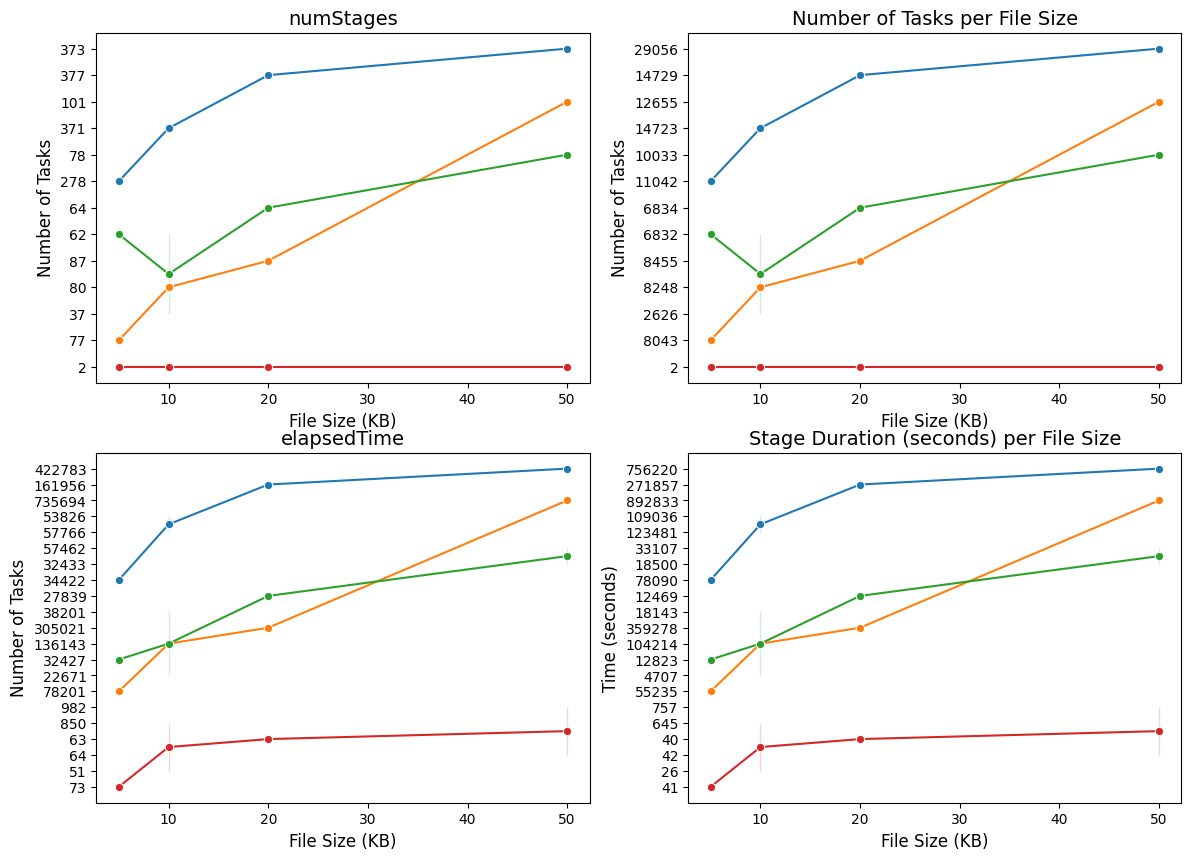

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

# Read data and prepare the DataFrame (as per your original steps)

# Path to the directory containing the CSV files, with a wildcard pattern
# This will match any file that ends with "_stage_metrics.csv" in the specified directory
csv_files_path = "/content/stage_metrics/*KB"

# Read all CSV files that match the pattern into a single Spark DataFrame
df_monitor = spark.read.csv(csv_files_path, header=True)

# Convert to Pandas DataFrame if needed for plotting
pdf_monitor = df_monitor.toPandas().dropna()
# Extract stage numbers from stage_name
pdf_monitor['stage_number'] = pdf_monitor['stage_name'].apply(lambda x: int(re.search(r'\d+', x).group()))
# add file size from dataset name as a column
pdf_monitor['file_size'] = pdf_monitor['dataset'].str.extract(r'dataset_(\d+)KB').astype(float)


pdf_plot_melted = pd.melt(pdf_monitor, id_vars=['stage_name', 'stage_number', 'file_size'], var_name='Metric', value_name='Value')



# Set up the plot with a reduced size
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=False)
axes = axes.flatten()

# Define custom titles for each metric
custom_titles = {
    'numTasks': 'Number of Tasks per File Size',
    'stageDuration': 'Stage Duration (seconds) per File Size',
    'peakExecutionMemory': 'Peak Execution Memory (KB) per File Size',
    'executorCpuTime': 'Executor CPU Time (seconds) per File Size'
}

# Plot each metric
metrics = pdf_plot_melted['Metric'].unique()
for i, metric in enumerate(metrics):
    ax = axes[i]
    data_metric = pdf_plot_melted[pdf_plot_melted['Metric'] == metric]
    sns.lineplot(data=data_metric, x='file_size', y='Value', hue='stage_name', marker='o', ax=ax, legend=False)
    ax.set_title(custom_titles.get(metric, metric), fontsize=14)
    ax.set_xlabel("File Size (KB)", fontsize=12)
    if metric == 'peakExecutionMemory':
        ax.set_ylabel("Peak Execution Memory (GB)", fontsize=12)
    elif metric in ('stageDuration', 'executorCpuTime'):
        ax.set_ylabel("Time (seconds)", fontsize=12)
    else:
        ax.set_ylabel("Number of Tasks", fontsize=12)

# Retrieve and add the legend with improved spacing and marker styles
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, title='Stage Names', bbox_to_anchor=(1.1, 0.5), loc='center right', borderaxespad=1,
#            frameon=False, handlelength=3, handletextpad=1)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Leave space for the legend on the right
plt.show()

In [ ]:
export_datasets_to_computer(folder_path="/content/dataset_5KB.csv_stage_metrics")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

All datasets have been exported to your computer.


In [ ]:
export_datasets_to_computer(folder_path="/content/dataset_10KB.csv_stage_metrics")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

All datasets have been exported to your computer.


In [ ]:
export_datasets_to_computer(folder_path="/content/dataset_20KB.csv_stage_metrics")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

All datasets have been exported to your computer.


In [ ]:
export_datasets_to_computer(folder_path="/content/dataset_30KB.csv_stage_metrics")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

All datasets have been exported to your computer.


In [ ]:
export_datasets_to_computer(folder_path="/content/dataset_50KB.csv_stage_metrics")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

All datasets have been exported to your computer.
